In [0]:
!pip install opencv-contrib-python
!pip install tensorflow==1.14.0
!pip install keras==2.3

     |████████████████████████████████| 109.2MB 87kB/s 
     |████████████████████████████████| 3.2MB 21.1MB/s 
     |████████████████████████████████| 491kB 43.0MB/s 
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


     |████████████████████████████████| 378kB 2.5MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
!pip install mlxtend

In [0]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import os
import math
from scipy import ndimage
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import argparse
import cv2
import os
import re
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [0]:
data_test = np.load('/content/drive/My Drive/MYDB/data.npy')
labels_test = np.load('/content/drive/My Drive/MYDB/labels.npy')

# histories = np.load('/content/drive/My Drive/MYDB/histories.npy')
# scores = np.load('/content/drive/My Drive/MYDB/scores.npy')


In [0]:
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY


In [0]:
# SCALE PIXELS
def prep_pixels(train):
	# convert from integers to floats
	train_norm = train.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	# return normalized images
	return train_norm

In [0]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(31, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [0]:
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=60, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)

		# Plot confusion matrix
		y_pred = model.predict_classes(testX)
		# print('testY')
		# print(np.argmax(testY, axis=1))
		# print('y_pred')
		# print(y_pred)

		font = {
		'family': 'Times New Roman',
		'size': 12
		}
		matplotlib.rc('font', **font)
		mat = confusion_matrix(np.argmax(testY, axis=1), y_pred)
		plot_confusion_matrix(conf_mat=mat, figsize=(24, 24), show_normed=True)
	return scores, histories

In [0]:
def evaluate_model_generator(dataX, dataY, n_folds=5):
  scores, histories = list(), list()
  datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    zoom_range=[0.5,1.0],
    shear_range=0.1
    )
  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
    model = define_model()
    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fits the model on batches with real-time data augmentation:
    history = model.fit_generator(datagen.flow(trainX, trainY, batch_size=32), validation_data=(testX, testY),
                    steps_per_epoch=len(testX) / 32, epochs = 30)
    # fit model
    # history = model.fit(trainX, trainY, epochs=60, batch_size=32, validation_data=(testX, testY), verbose=0)
    
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
    # stores scores
    scores.append(acc)
    histories.append(history)

    # Plot confusion matrix
    y_pred = model.predict_classes(testX)
    # print('testY')
    # print(np.argmax(testY, axis=1))
    # print('y_pred')
    # print(y_pred)

    font = {
    'family': 'Times New Roman',
    'size': 12
    }
    matplotlib.rc('font', **font)
    mat = confusion_matrix(np.argmax(testY, axis=1), y_pred)
    plot_confusion_matrix(conf_mat=mat, figsize=(24, 24), show_normed=True)
    model.save('/content/drive/My Drive/MYDB/30EpochDataAug_model.h5')
  return scores, histories

In [0]:
help(fit_generator)

In [0]:
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='green', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='red', label='test')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='green', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='red', label='test')
	pyplot.show()

In [0]:
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

> 96.675
> 96.186
> 97.066
> 96.578
> 96.903


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


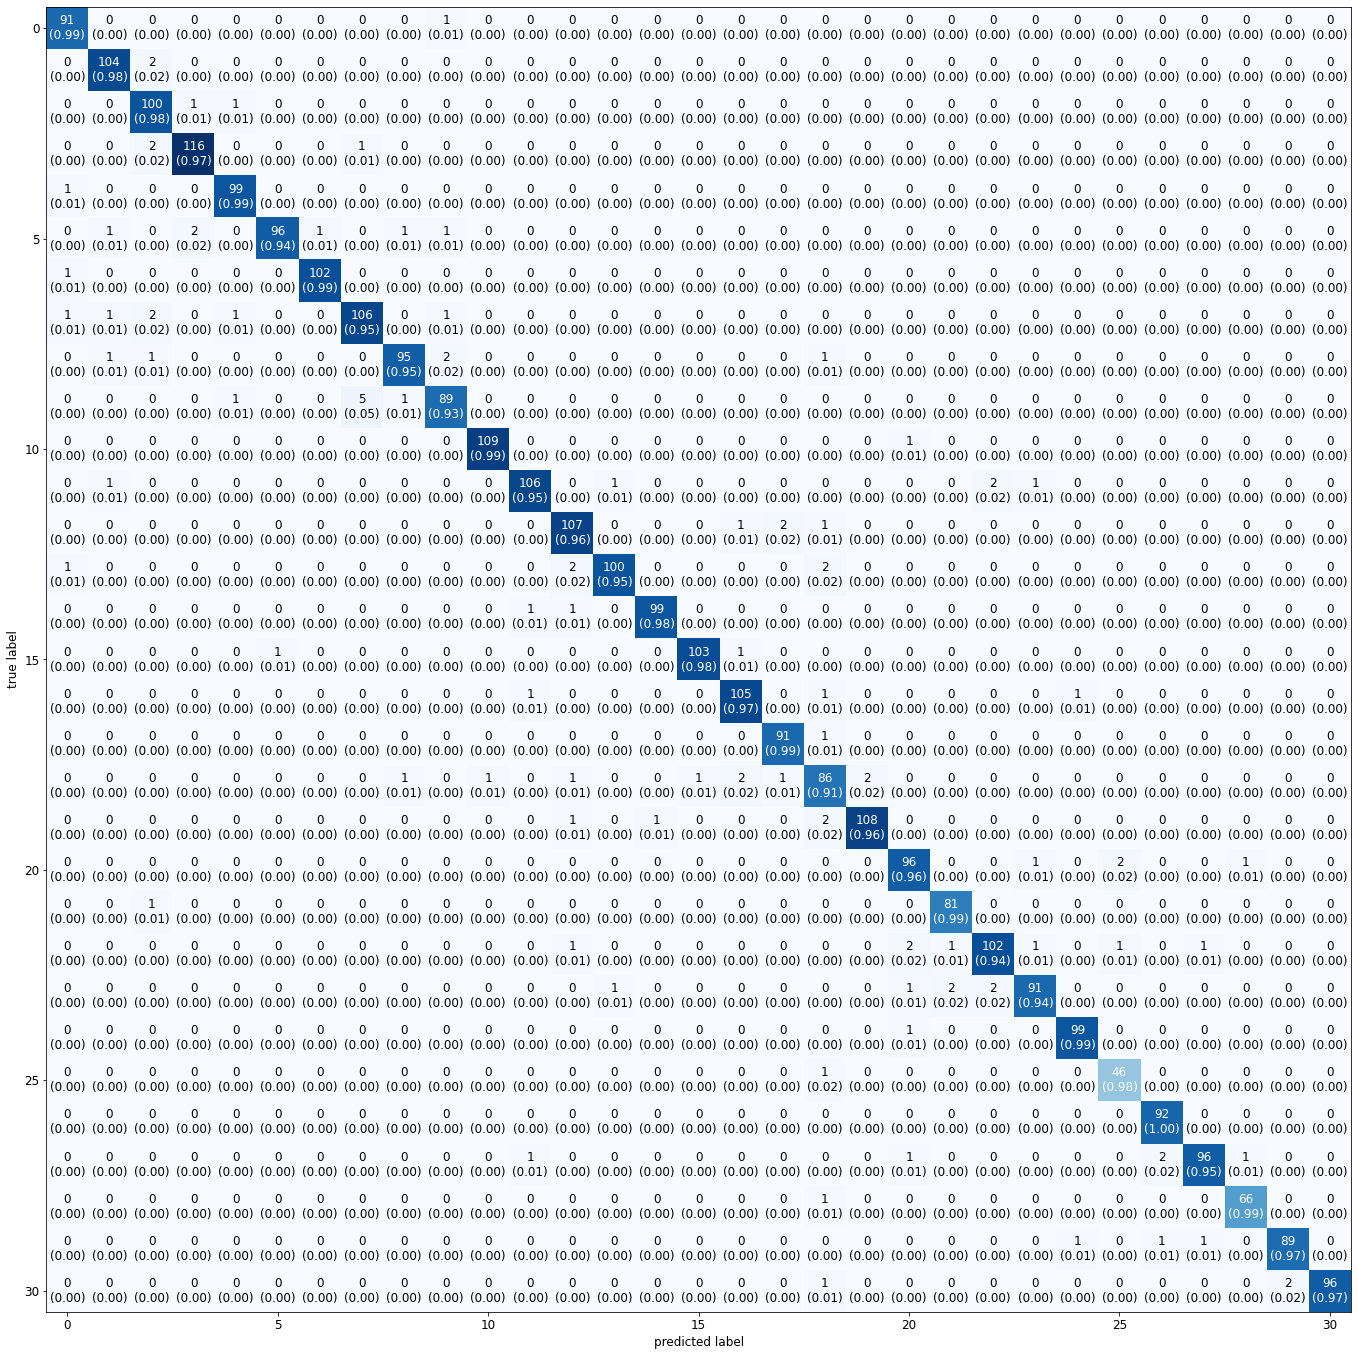

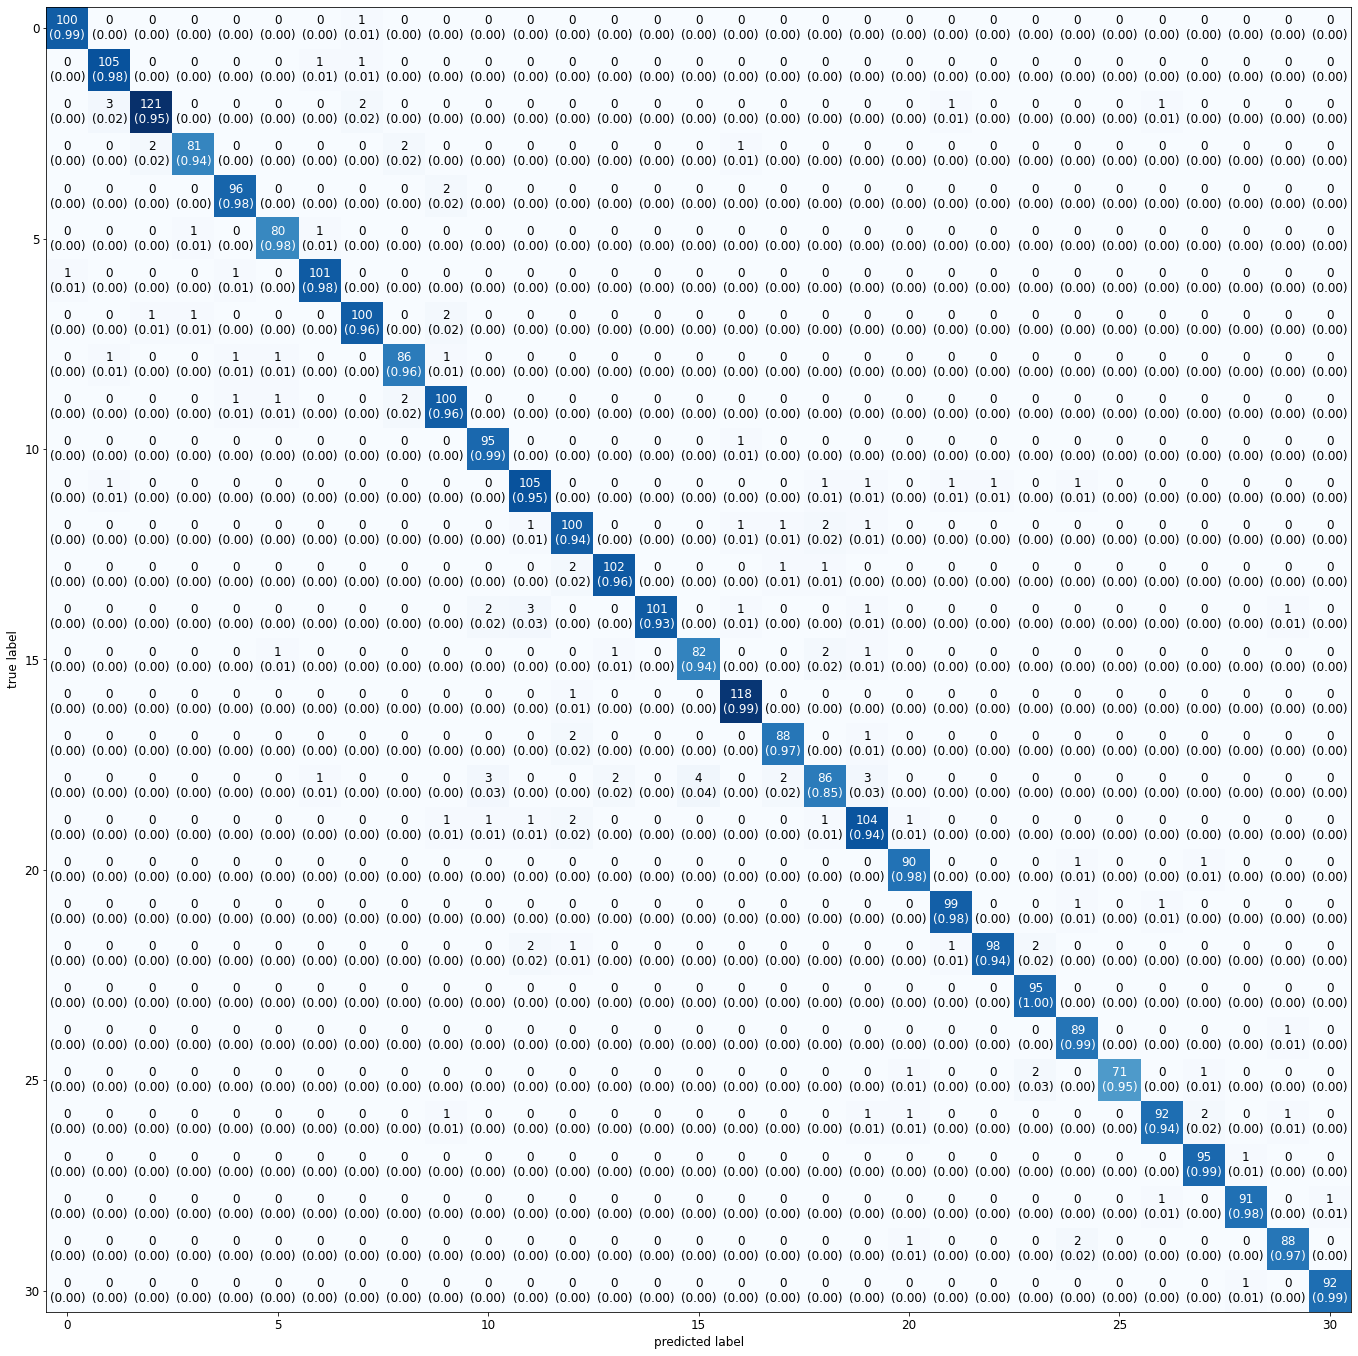

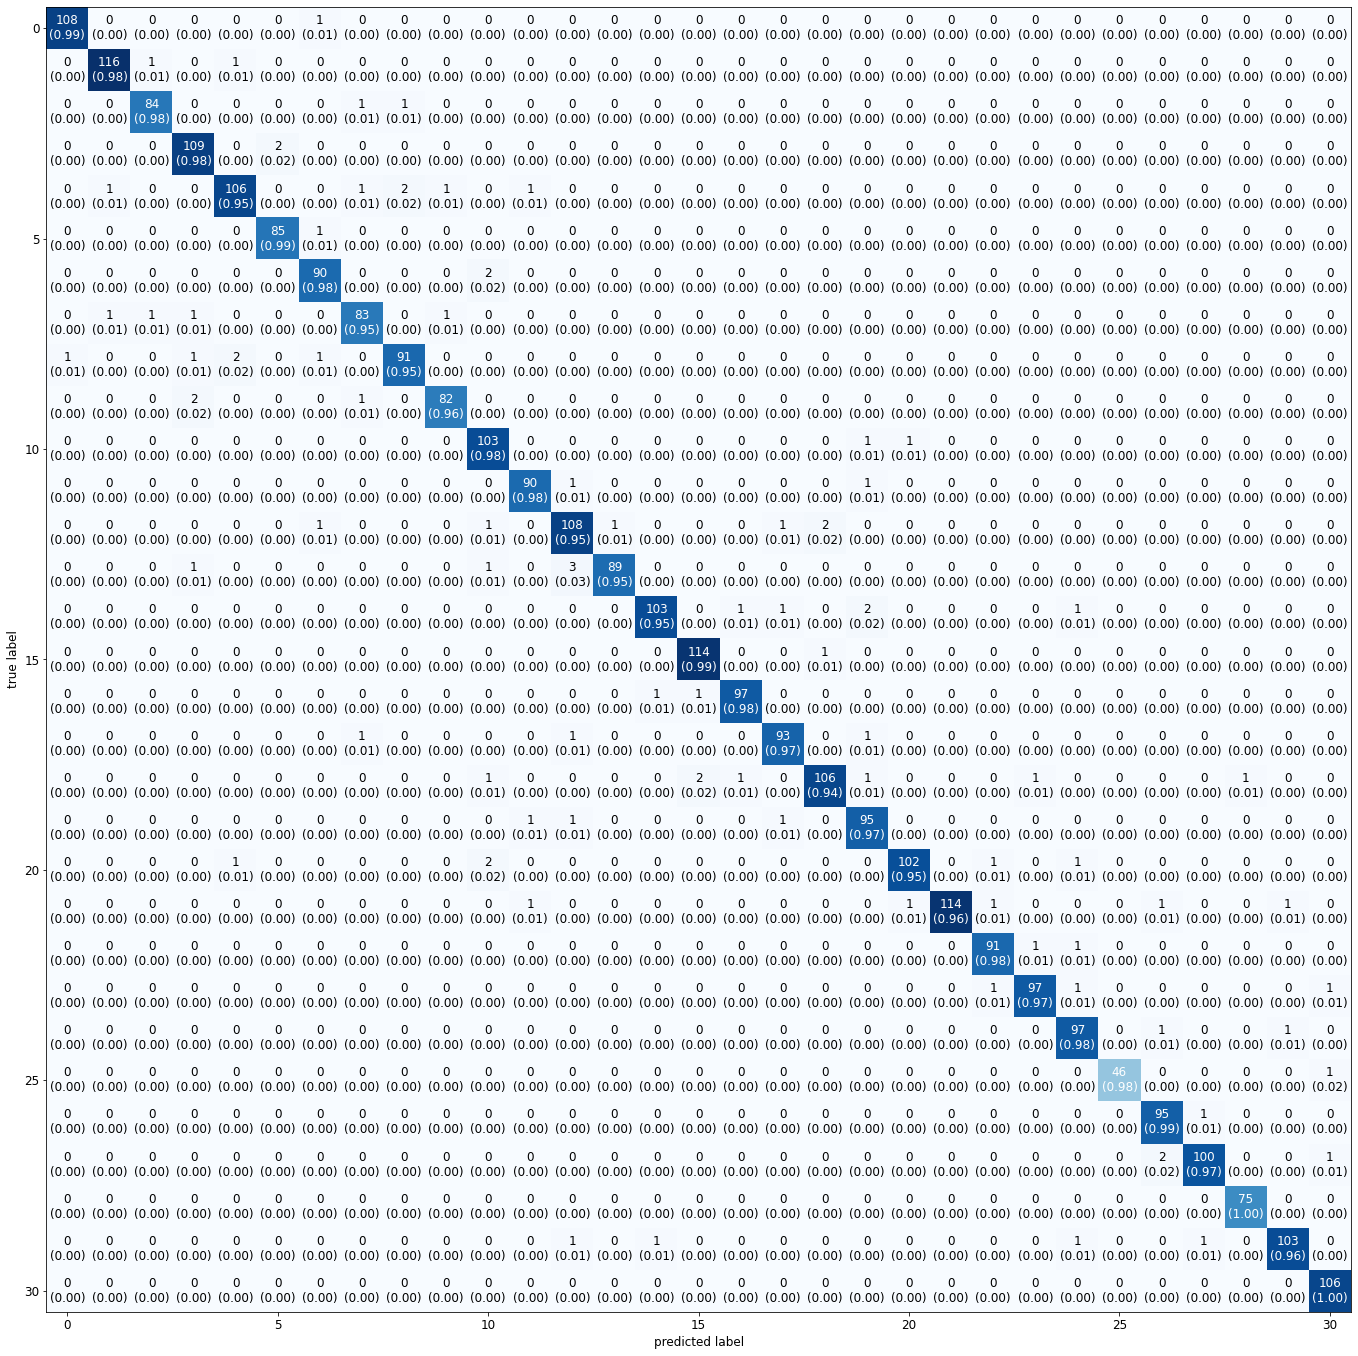

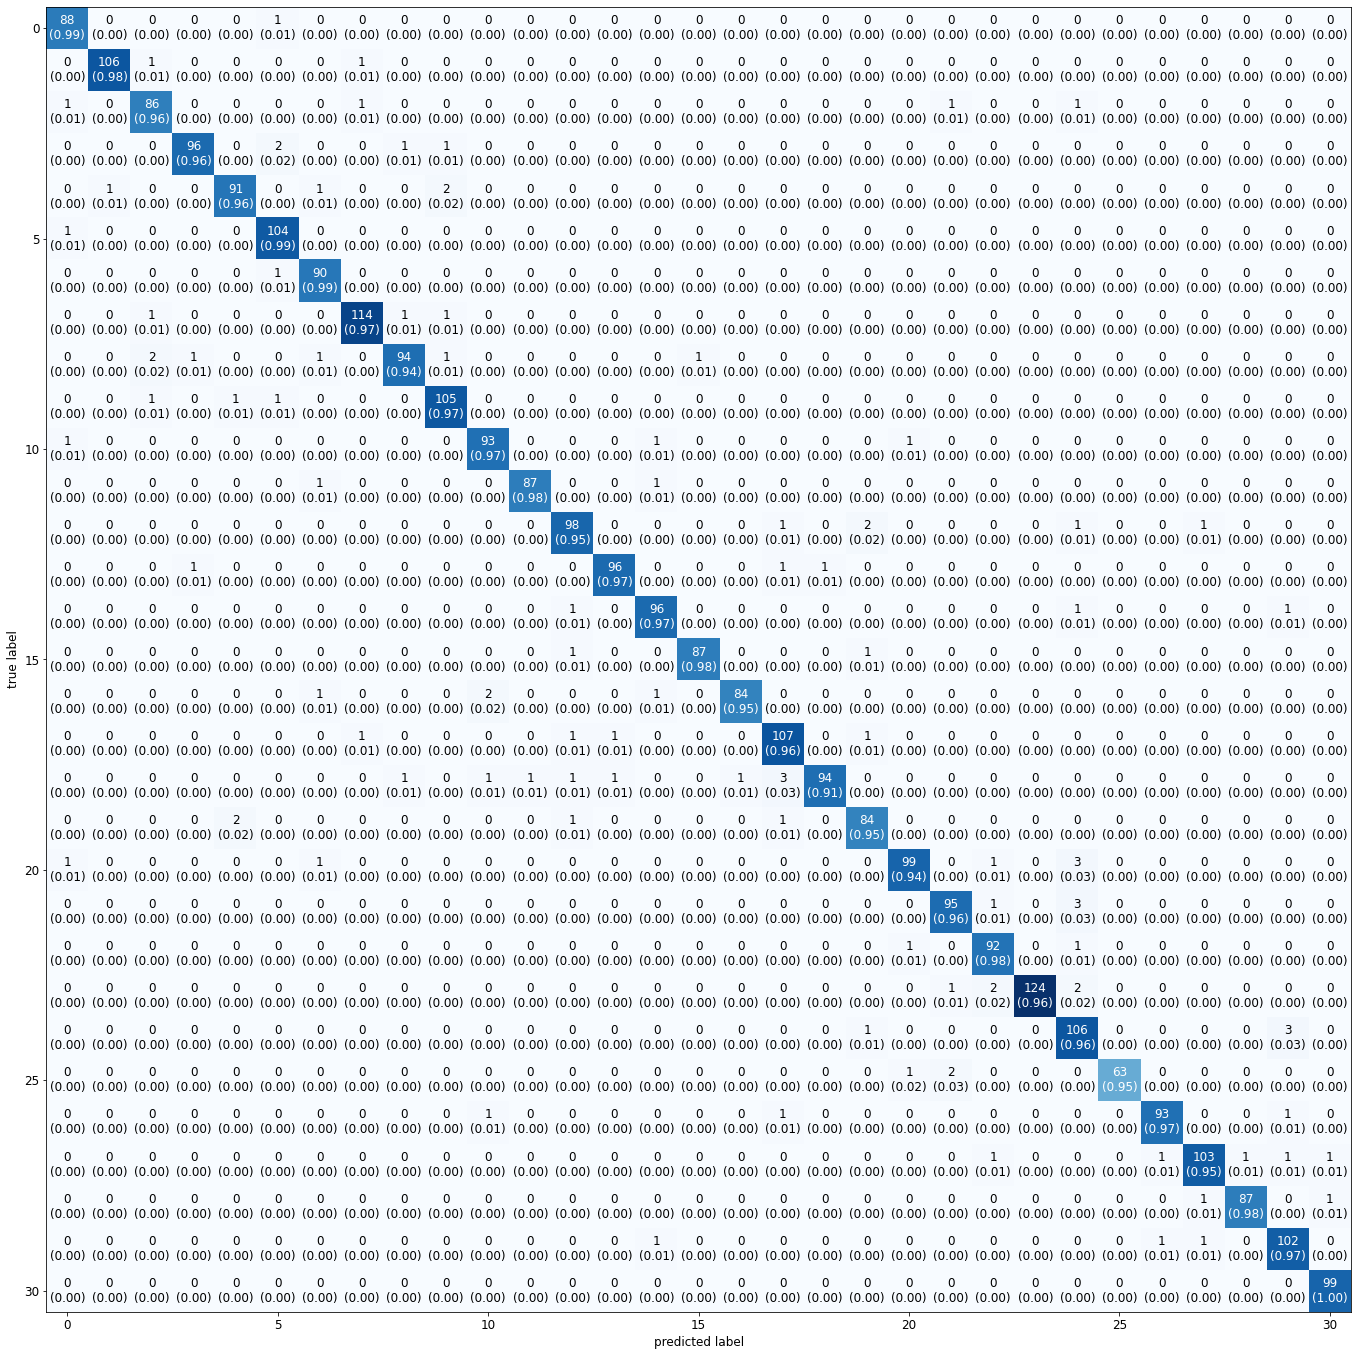

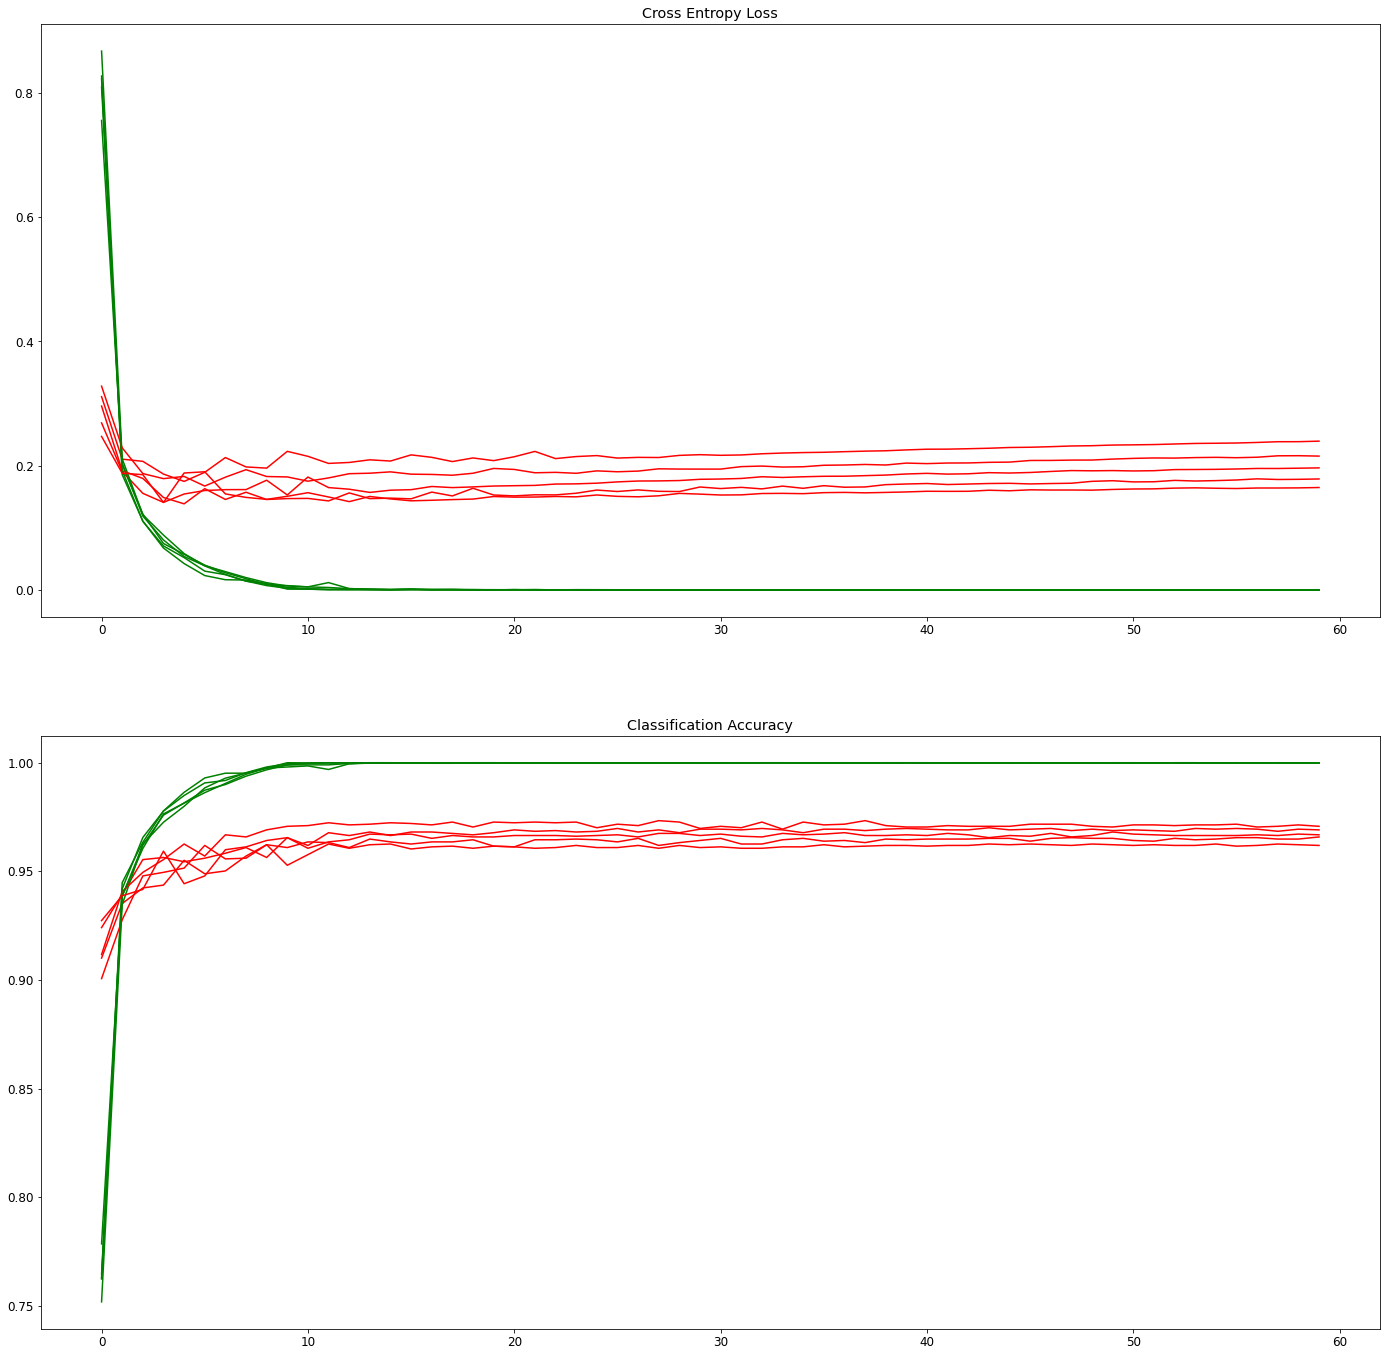

Accuracy: mean=96.682 std=0.301, n=5


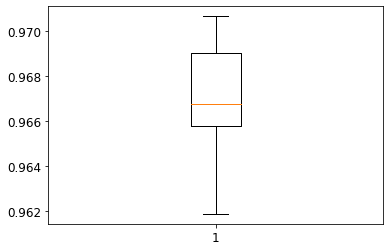

In [0]:
# load dataset
# reshape dataset to have a single channel
data_test = data_test.reshape((data_test.shape[0], 28, 28, 1))
# prepare pixel data
trainX = prep_pixels(data_test)
# Encode labels
trainY = to_categorical(labels_test)
# Evaluate model
# scores, histories = evaluate_model(trainX, trainY)
# Evaluate model with augmented data
scores, histories = evaluate_model_generator(trainX, trainY)
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30
96/95 [==============================] - 7s 70ms/step - loss: 2.3936 - accuracy: 0.3294 - val_loss: 1.6875 - val_accuracy: 0.4772
Epoch 2/30
96/95 [==============================] - 6s 67ms/step - loss: 1.0176 - accuracy: 0.6969 - val_loss: 1.1932 - val_accuracy: 0.6219
Epoch 3/30
96/95 [==============================] - 6s 68ms/step - loss: 0.7122 - accuracy: 0.7812 - val_loss: 0.8111 - val_accuracy: 0.7392
Epoch 4/30
96/95 [==============================] - 6s 67ms/step - loss: 0.5883 - accuracy: 0.8262 - val_loss: 0.5390 - val_accuracy: 0.8243
Epoch 5/30
96/95 [==============================] - 6s 67ms/step - loss: 0.4817 - accuracy: 0.8535 - val_loss: 0.5740 - val_accuracy: 0.8220
Epoch 6/30
96/95 [==============================] - 7s 68ms/step - loss: 0.4169 - accuracy: 0.8714 - val_loss: 0.4870 - val_accuracy: 0.8449
Epoch 7/30
96/95 [==============================] - 7s 69ms/step - loss: 0.3918 - accuracy: 0.8783 - val_loss: 0.4274 - val_accuracy: 0.8683
Epoch 8/30
96

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30
96/95 [==============================] - 7s 70ms/step - loss: 2.3668 - accuracy: 0.3288 - val_loss: 1.6082 - val_accuracy: 0.5231
Epoch 2/30
96/95 [==============================] - 7s 68ms/step - loss: 1.0156 - accuracy: 0.6881 - val_loss: 0.9539 - val_accuracy: 0.6822
Epoch 3/30
96/95 [==============================] - 6s 67ms/step - loss: 0.6930 - accuracy: 0.7819 - val_loss: 0.7835 - val_accuracy: 0.7748
Epoch 4/30
96/95 [==============================] - 6s 67ms/step - loss: 0.5674 - accuracy: 0.8236 - val_loss: 0.5909 - val_accuracy: 0.8136
Epoch 5/30
96/95 [==============================] - 7s 68ms/step - loss: 0.4832 - accuracy: 0.8464 - val_loss: 0.6548 - val_accuracy: 0.8054
Epoch 6/30
96/95 [==============================] - 7s 68ms/step - loss: 0.4280 - accuracy: 0.8636 - val_loss: 0.5983 - val_accuracy: 0.8299
Epoch 7/30
96/95 [==============================] - 7s 68ms/step - loss: 0.3912 - accuracy: 0.8770 - val_loss: 0.4628 - val_accuracy: 0.8644
Epoch 8/30
96

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30
96/95 [==============================] - 7s 68ms/step - loss: 2.4958 - accuracy: 0.2946 - val_loss: 1.8902 - val_accuracy: 0.4436
Epoch 2/30
96/95 [==============================] - 6s 65ms/step - loss: 1.1441 - accuracy: 0.6598 - val_loss: 1.0669 - val_accuracy: 0.6793
Epoch 3/30
96/95 [==============================] - 6s 66ms/step - loss: 0.7261 - accuracy: 0.7738 - val_loss: 1.1225 - val_accuracy: 0.6460
Epoch 4/30
96/95 [==============================] - 6s 66ms/step - loss: 0.6311 - accuracy: 0.8072 - val_loss: 0.5741 - val_accuracy: 0.8354
Epoch 5/30
96/95 [==============================] - 6s 65ms/step - loss: 0.4939 - accuracy: 0.8464 - val_loss: 0.5453 - val_accuracy: 0.8302
Epoch 6/30
96/95 [==============================] - 6s 66ms/step - loss: 0.4858 - accuracy: 0.8525 - val_loss: 0.5695 - val_accuracy: 0.8286
Epoch 7/30
96/95 [==============================] - 6s 65ms/step - loss: 0.4219 - accuracy: 0.8681 - val_loss: 0.6444 - val_accuracy: 0.8028
Epoch 8/30
96

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30
96/95 [==============================] - 7s 70ms/step - loss: 2.3497 - accuracy: 0.3483 - val_loss: 1.5148 - val_accuracy: 0.5391
Epoch 2/30
96/95 [==============================] - 7s 68ms/step - loss: 1.0135 - accuracy: 0.6921 - val_loss: 0.9082 - val_accuracy: 0.7200
Epoch 3/30
96/95 [==============================] - 6s 68ms/step - loss: 0.6395 - accuracy: 0.8036 - val_loss: 0.7919 - val_accuracy: 0.7627
Epoch 4/30
96/95 [==============================] - 6s 68ms/step - loss: 0.5574 - accuracy: 0.8278 - val_loss: 0.5348 - val_accuracy: 0.8299
Epoch 5/30
96/95 [==============================] - 7s 68ms/step - loss: 0.4836 - accuracy: 0.8606 - val_loss: 0.5362 - val_accuracy: 0.8400
Epoch 6/30
96/95 [==============================] - 7s 68ms/step - loss: 0.4290 - accuracy: 0.8678 - val_loss: 0.5574 - val_accuracy: 0.8220
Epoch 7/30
96/95 [==============================] - 7s 69ms/step - loss: 0.4066 - accuracy: 0.8802 - val_loss: 0.6898 - val_accuracy: 0.7859
Epoch 8/30
96

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/30
96/95 [==============================] - 7s 69ms/step - loss: 2.4439 - accuracy: 0.3171 - val_loss: 1.7873 - val_accuracy: 0.4473
Epoch 2/30
96/95 [==============================] - 7s 68ms/step - loss: 1.0311 - accuracy: 0.6930 - val_loss: 0.8122 - val_accuracy: 0.7467
Epoch 3/30
96/95 [==============================] - 6s 67ms/step - loss: 0.6675 - accuracy: 0.8031 - val_loss: 0.7202 - val_accuracy: 0.7952
Epoch 4/30
96/95 [==============================] - 6s 67ms/step - loss: 0.5776 - accuracy: 0.8200 - val_loss: 0.6814 - val_accuracy: 0.7871
Epoch 5/30
96/95 [==============================] - 7s 68ms/step - loss: 0.4424 - accuracy: 0.8623 - val_loss: 0.4667 - val_accuracy: 0.8611
Epoch 6/30
96/95 [==============================] - 6s 67ms/step - loss: 0.4373 - accuracy: 0.8671 - val_loss: 0.5256 - val_accuracy: 0.8305
Epoch 7/30
96/95 [==============================] - 7s 68ms/step - loss: 0.3907 - accuracy: 0.8883 - val_loss: 0.5603 - val_accuracy: 0.8256
Epoch 8/30
96

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


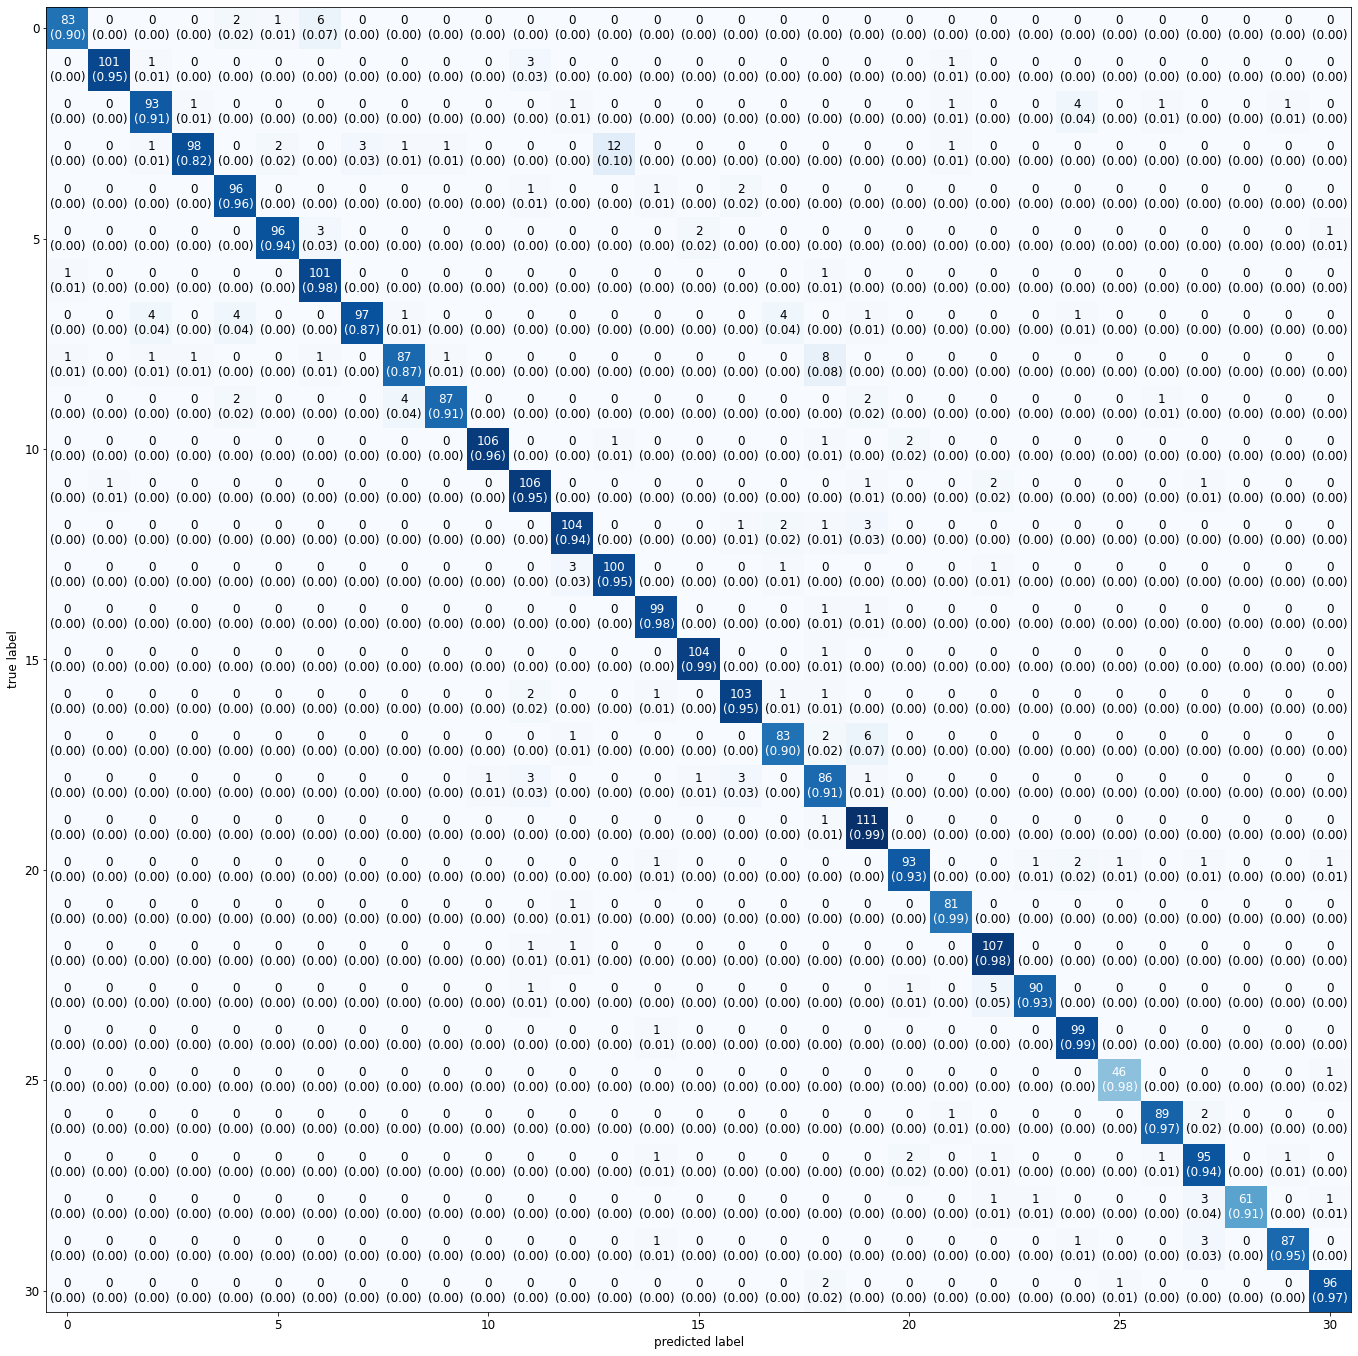

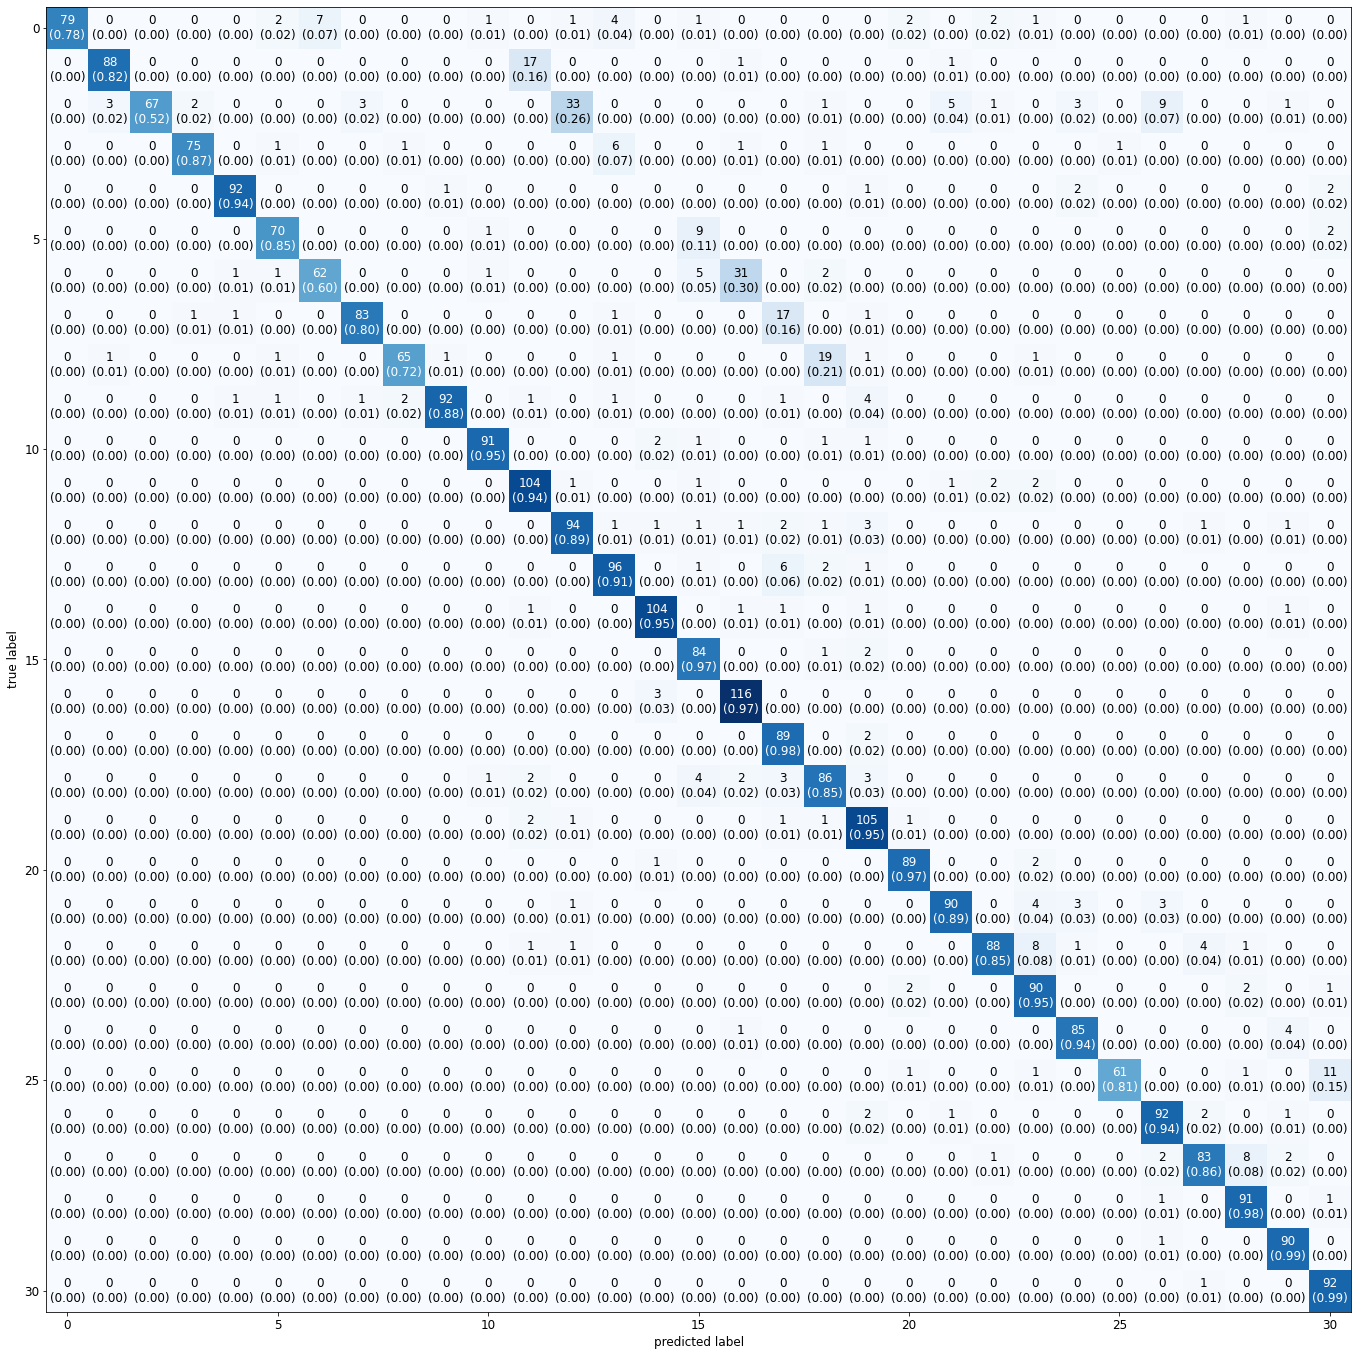

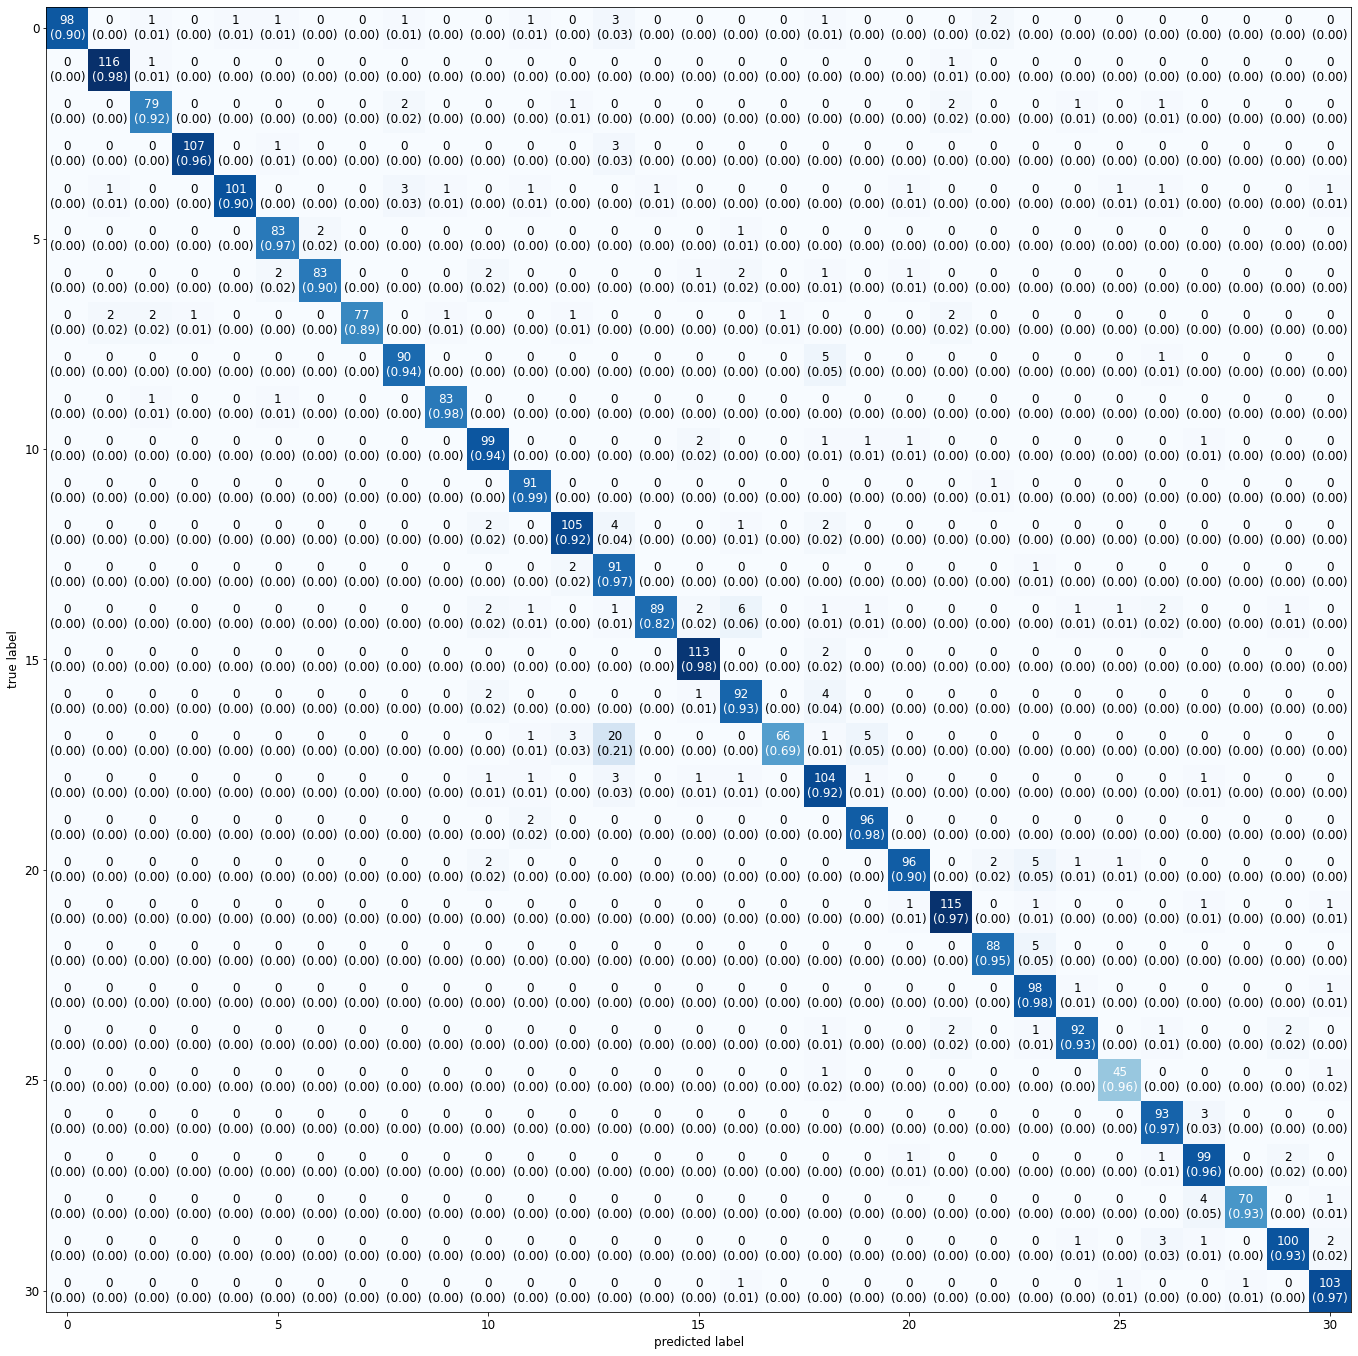

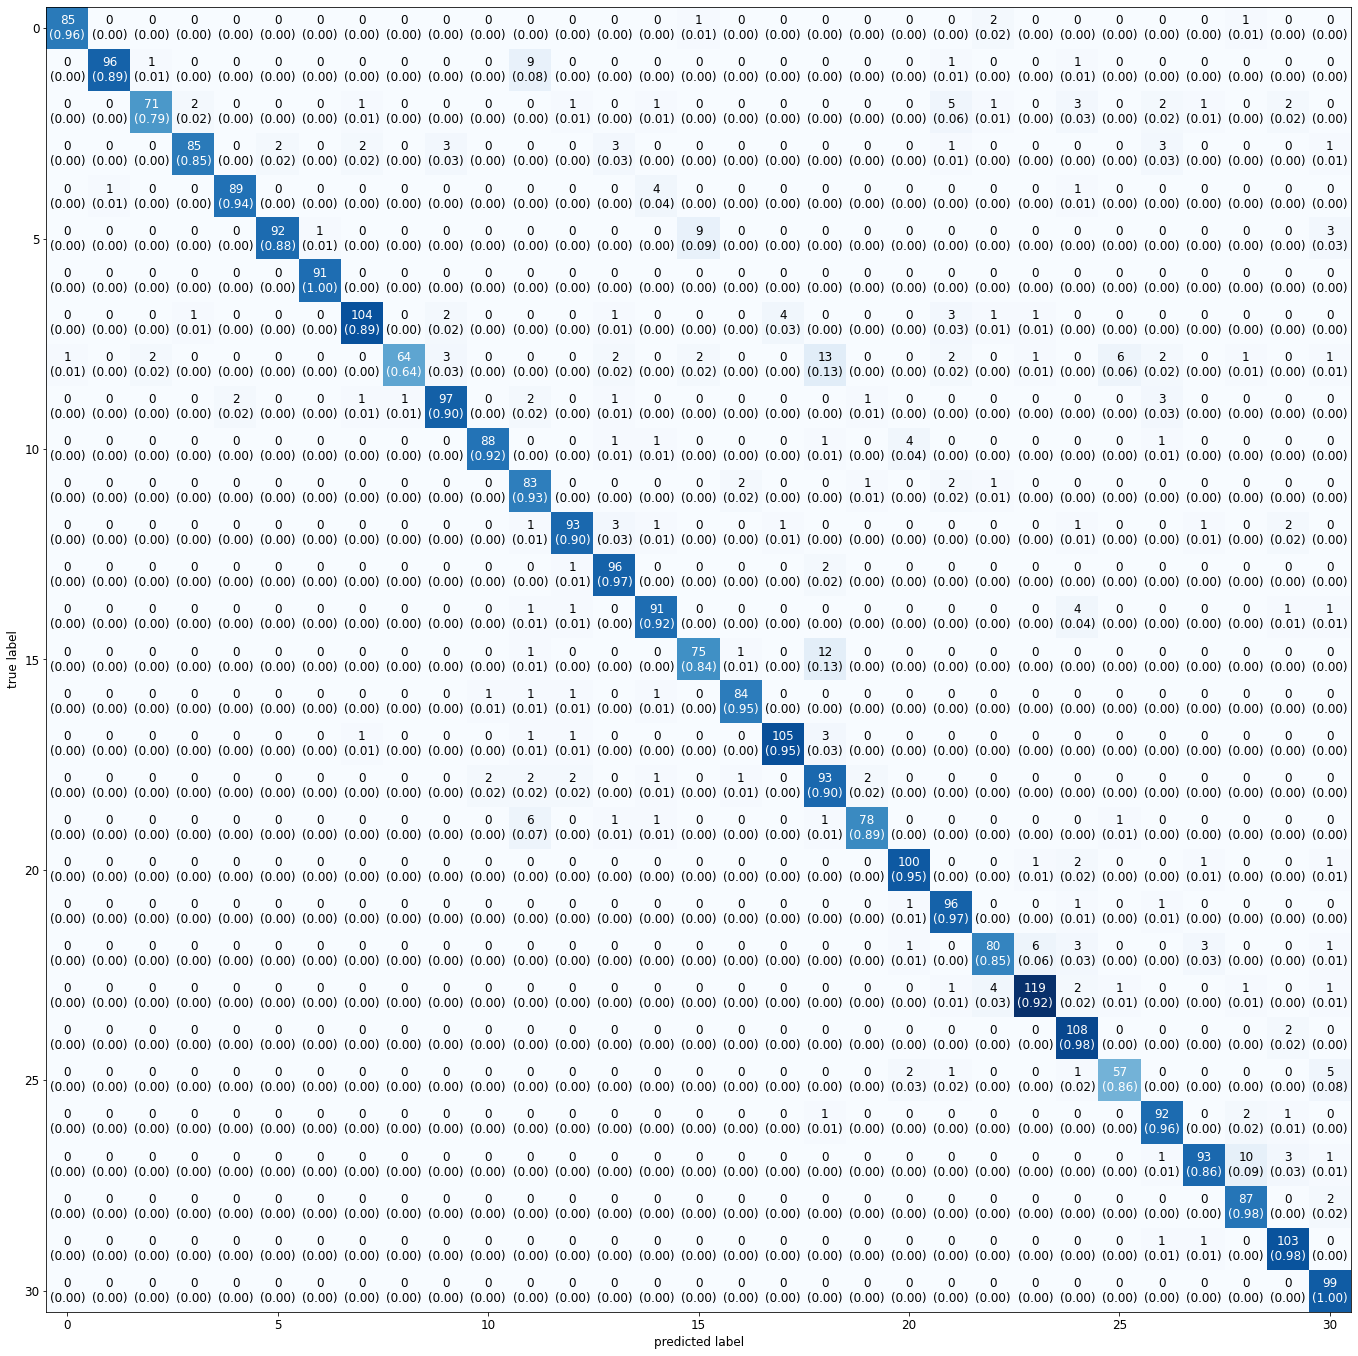

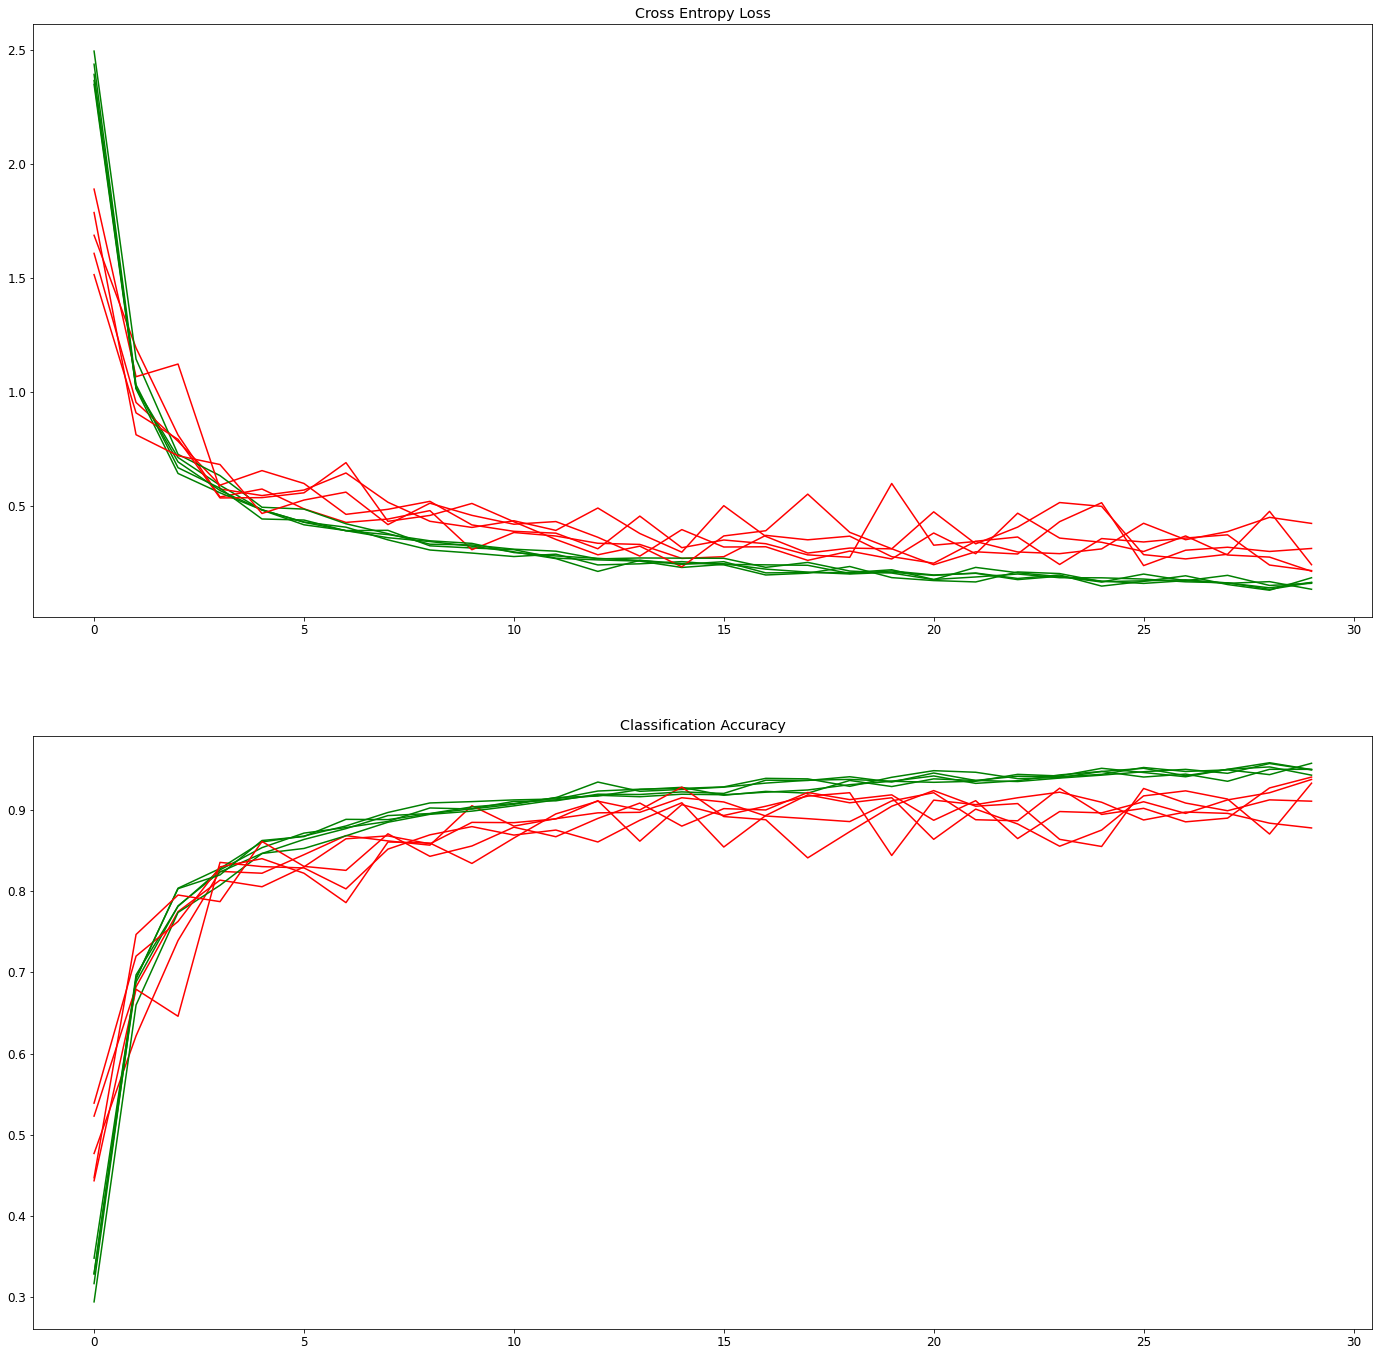

Accuracy: mean=91.981 std=2.346, n=5


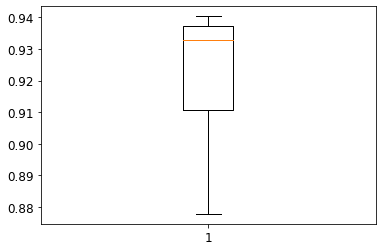

In [0]:
# WITH DATA GENERATOR
# load dataset
# reshape dataset to have a single channel
data_test = data_test.reshape((data_test.shape[0], 28, 28, 1))
# prepare pixel data
trainX = prep_pixels(data_test)
# Encode labels
trainY = to_categorical(labels_test)
# Evaluate model with augmented data
scores, histories = evaluate_model_generator(trainX, trainY)
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)